In [21]:
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import logging

import torch
import torch.nn as nn
import torch.nn.functional as F

from EduCDM import EMDINA as DINA

In [2]:
# MPSでサポートしていない演算を実行する際に、CPUにフォールバックするように設定
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

use_cuda = torch.cuda.is_available()
use_mps = torch.backends.mps.is_available()

if use_cuda:
    device = torch.device("cuda")
# elif use_mps:
#     device = torch.device("mps")
else:
    device = torch.device("cpu")
    
print(f"CUDA available: {use_cuda}")
print(f"MPS available: {use_mps}")
print(f"Using device: {device}")

CUDA available: False
MPS available: True
Using device: cpu


In [3]:
def set_seed(seed):
    random.seed(seed)  # Pythonのrandomモジュールのシードを固定
    np.random.seed(seed)  # NumPyのシードを固定
    torch.manual_seed(seed)  # PyTorchのCPUシードを固定
    torch.cuda.manual_seed(seed)  # PyTorchのGPUシードを固定
    torch.cuda.manual_seed_all(seed)  # マルチGPU環境でのシード固定
    torch.backends.cudnn.deterministic = True  # 再現性のためにCuDNNを固定
    torch.backends.cudnn.benchmark = False  # 再現性のためにCuDNNベンチマークをOFF

set_seed(0)

## 実データ(EdNet)

### 演習データ読み込み

In [4]:
# user_question.csv ファイルを読み込み
"""
question_id,users
ex:q3628,"u20746,u21660,u20556,u21202,u21240"
"""
question_users = pd.read_csv("question_user.csv")

# 解かれている問題が多い順に並べ替え
# "users" カラムに split を適用してリストに変換
question_users["users"] = question_users["users"].apply(lambda x: x.split(","))

# 各質問に対するユーザー数を計算
question_users["user_count"] = question_users["users"].apply(len)

# user_count を基準に降順で並べ替え
question_users = question_users.sort_values(by="user_count", ascending=False)

print(question_users.head())

    question_id                                              users  user_count
926       q8098  [u145488, u50282, u61533, u11235, u237242, u92...      232037
489       q8074  [u50282, u61533, u11235, u237242, u92681, u220...      228334
397        q176  [u50282, u263254, u61533, u11235, u237242, u22...      227029
927       q1279  [u50282, u61533, u11235, u237242, u351207, u22...      203468
940       q6185  [u50282, u263254, u61533, u11235, u237242, u36...      191156


In [5]:
# topk 個の質問に回答している学生のみを抽出
topk = 10
top_questions = question_users["question_id"].head(topk).tolist()

# topk の質問に関連付けられたユーザーを絞り込み
if top_questions:
    # 対応するユーザーを取得し、セットとして管理
    common_users = set.intersection(
        *(
            set(question_users.loc[question_users["question_id"] == question, "users"].iloc[0])
            for question in top_questions
        )
    )
else:
    common_users = set()

# ユーザーのリストをソート
common_users = sorted(common_users)

# 結果を出力
print(f"Top {topk} questions: {top_questions}")
print(f"Number of common users: {len(common_users)}")
print(f"Common users: {list(common_users)[:10]}")

Top 10 questions: ['q8098', 'q8074', 'q176', 'q1279', 'q6185', 'q6243', 'q2068', 'q2067', 'q2069', 'q4178']
Number of common users: 158607
Common users: ['u100001', 'u100002', 'u100003', 'u100004', 'u100005', 'u100007', 'u100008', 'u100009', 'u100010', 'u100011']


### Q行列の作成

In [6]:
# questions.csv から該当するtagsを取得
questions_file_path = 'questions.csv'
questions_df = pd.read_csv(questions_file_path)

# top_questions に対応するデータを抽出
filtered_questions = questions_df[questions_df["question_id"].isin(top_questions)]

# 対応表の作成。問題にスキルを紐づける
question_tag_mapping = filtered_questions[["question_id", "tags"]]
question_tag_mapping = question_tag_mapping.copy()
question_tag_mapping["tags"] = question_tag_mapping["tags"].apply(lambda x: x.split(";"))

# スキルと問題の行と列のインデックスを定義
all_tags = [tag for tags in question_tag_mapping["tags"] for tag in tags]
unique_tags = set(all_tags)
unique_tags = sorted(unique_tags)
question_index_mapping = {qid: idx for idx, qid in enumerate(top_questions)} # 回答者が多い順になっている
tag_index_mapping = {tag: idx for idx, tag in enumerate(unique_tags)} # スキルの番号順

# Q行列を作成
Q_matrix = np.zeros((len(top_questions), len(unique_tags)), dtype=int)
for _, row in question_tag_mapping.iterrows():
    question_id = row["question_id"]
    if question_id in question_index_mapping:  # top_questions に存在する場合のみ処理
        question_idx = question_index_mapping[question_id]
        for tag in row["tags"]:
            if tag in tag_index_mapping:
                tag_idx = tag_index_mapping[tag]
                Q_matrix[question_idx, tag_idx] = 1

print(f"Unique tags: {unique_tags}")
print(f"問題×スキル: {len(Q_matrix)}×{len(unique_tags)}")
print(Q_matrix)
# print(question_tag_mapping)

Unique tags: ['100', '11', '145', '179', '182', '183', '184', '2', '24', '26', '5', '52', '55', '6', '7', '75']
問題×スキル: 10×16
[[0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0]
 [0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0]
 [0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0]
 [0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]]


### 2回分のテストを作成

In [7]:
# ユーザーそれぞれの演習ファイル
folder_path = "KT1"

# 正誤結果を記録するリスト
R = []
R2 = []

max_users = 500
count_users = 0

n_questions = len(top_questions)

# 該当学生のファイルのみ処理
for user_id in tqdm(common_users):
    file_path = os.path.join(folder_path, f"{user_id}.csv")
    
    if os.path.isfile(file_path):
        user_df = pd.read_csv(file_path)
        
        # 前後半に分割
        mid_index = len(user_df) // 2
        first_half = user_df.iloc[:mid_index]
        second_half = user_df.iloc[mid_index:]
        
        # 前半部分に top_questions がすべて含まれているかを判定
        questions_in_first_half = set(first_half["question_id"])
        all_included_first_half = set(top_questions).issubset(questions_in_first_half)
        # 後半部分に top_questions がすべて含まれているかを判定
        questions_in_second_half = set(second_half["question_id"])
        all_included_second_half = set(top_questions).issubset(questions_in_second_half)

        # 前後半ともに含んでいた場合
        if all_included_first_half and all_included_second_half:
            # 個人の回答結果
            R_list = [None] * n_questions
            R2_list = [None] * n_questions

            # top_questions に含まれる問題をフィルタリング
            """注意：最も直近の値が格納されている"""
            # 1回目テスト
            first_questions = first_half[first_half["question_id"].isin(top_questions)]
            # 正解判定
            for _, question_row in first_questions.iterrows():
                question_id = question_row["question_id"]
                user_answer = question_row["user_answer"]
                
                # 正解を取得
                correct_answer = questions_df.loc[questions_df["question_id"] == question_id, "correct_answer"].iloc[0]
                
                # 判定：正解なら1、不正解なら0
                is_correct = 1 if user_answer == correct_answer else 0
                
                # R の該当箇所に結果を記録
                # user_idx = user_index_mapping[user_id]  # ユーザーのインデックス
                question_idx = top_questions.index(question_id)  # 質問のインデックス
                R_list[question_idx] = is_correct
            R.append(R_list)

            # 2回目テスト
            second_questions = second_half[second_half["question_id"].isin(top_questions)]
            # 正解判定
            for _, question in second_questions.iterrows():
                question_id = question["question_id"]
                user_answer = question["user_answer"]
                
                # 正解を取得
                correct_answer = questions_df.loc[questions_df["question_id"] == question_id, "correct_answer"].iloc[0]
                
                is_correct = 1 if user_answer == correct_answer else 0

                question_idx = top_questions.index(question_id)
                R2_list[question_idx] = is_correct
            R2.append(R2_list)

R = np.array(R, dtype=float)
R2 = np.array(R2, dtype=float)
np.save("R.npy", R)
np.save("R2.npy", R2)

100%|██████████| 158607/158607 [03:07<00:00, 848.16it/s]


In [ ]:
R = np.load("R.npy")
R2 = np.load("R2.npy")

# 同期シャッフル用のインデックスを生成
shuffle_indices = np.random.permutation(R.shape[0])

# インデックスを適用してシャッフル
R = R[shuffle_indices]
R2 = R2[shuffle_indices]

# 学生数
# print(f"Number of students: {R.shape}")
# print(f"Number of students: {R2.shape}")

# **None と NaN の確認関数** 
def check_missing_values(array, name):
    # None の検出
    if np.any(array == None):  # `is None` は配列全体には使えないため `== None` を使用
        print(f"⚠️ アラート: {name} に 'None' が含まれています。")

    # NaN の検出
    if np.issubdtype(array.dtype, np.number):  # 数値型のときのみ np.isnan を使う
        if np.isnan(array).any():
            print(f"⚠️ アラート: {name} に 'NaN' が含まれています。")

# チェック実行
check_missing_values(R, "R")
check_missing_values(R2, "R2")

In [9]:
# # NumPy 配列の全表示設定
np.set_printoptions(threshold=np.inf)

# 結果を表示
print("R matrix:")
print(R.shape)
print(R[:3])

print("R2 matrix:")
print(R2.shape)
print(R2[:3])

diff = R2-R

# 1 の数をカウント
count_1 = np.count_nonzero(diff == 1)
# -1 の数をカウント
count_minus_1 = np.count_nonzero(diff == -1)

print(f"新たに正解した数: {count_1}")
print(f"新たに間違えた数: {count_minus_1}")

R matrix:
(283, 10)
[[1. 1. 1. 1. 0. 1. 0. 0. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 1. 0. 1. 1. 0. 0.]]
R2 matrix:
(283, 10)
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 1. 1. 0. 1.]
 [1. 1. 0. 0. 0. 0. 1. 0. 0. 1.]]
新たに正解した数: 598
新たに間違えた数: 319


## CDM（認知診断モデル）

In [10]:
# ファイルを設定
CDM_dir = "./EdNet_CDM"
os.makedirs(CDM_dir, exist_ok=True)


### 1回目習得スキル

In [11]:
# データの形状取得
stu_num, prob_num = R.shape
_, know_num = Q_matrix.shape

# ログレベルを設定
logging.getLogger().setLevel(logging.INFO)

# DINAモデルの初期化
cdm = DINA(R, Q_matrix, stu_num, prob_num, know_num, skip_value=-1)# モデルの訓練

cdm.train(epoch=10, epsilon=1e-3)  # epochやepsilonは調整可能

# 訓練済みモデルの保存
CDM_path = os.path.join(CDM_dir, 'EdNet_dina_model.params')
cdm.save(CDM_path)

# モデルの評価 (RMSE, MAE)
rmse, mae = cdm.eval([{'user_id': i, 'item_id': j, 'score': R[i, j]}
                      for i in range(stu_num) for j in range(prob_num) if R[i, j] != -1])
print("RMSE: %.6f, MAE: %.6f" % (rmse, mae))


INFO:root:save parameters to ./EdNet_CDM/EdNet_dina_model.params
evaluating: 100%|██████████| 2830/2830 [00:00<00:00, 1064658.74it/s]

RMSE: 0.305491, MAE: 0.206669


### 2回目習得スキル

In [12]:
# データの形状取得
stu_num, prob_num = R2.shape
_, know_num = Q_matrix.shape

# ログレベルを設定
logging.getLogger().setLevel(logging.INFO)

# DINAモデルの初期化
cdm2 = DINA(R2, Q_matrix, stu_num, prob_num, know_num, skip_value=-1)# モデルの訓練

cdm2.train(epoch=10, epsilon=1e-3)  # epochやepsilonは調整可能

# 訓練済みモデルの保存
CDM_path2 = os.path.join(CDM_dir, 'EdNet_dina_model_2.params')
cdm2.save(CDM_path2)

# モデルの評価 (RMSE, MAE)
rmse, mae = cdm.eval([{'user_id': i, 'item_id': j, 'score': R2[i, j]}
                      for i in range(stu_num) for j in range(prob_num) if R2[i, j] != -1])
print("RMSE: %.6f, MAE: %.6f" % (rmse, mae))

INFO:root:save parameters to ./EdNet_CDM/EdNet_dina_model_2.params
evaluating: 100%|██████████| 2830/2830 [00:00<00:00, 1078785.81it/s]

RMSE: 0.489786, MAE: 0.353234


### 習得スキル

In [13]:
# 学習済みモデルのパラメータをロード
CDM_path = os.path.join(CDM_dir, 'EdNet_dina_model.params')
cdm.load(CDM_path)

attributes = []
# 学生ごとのアトリビュート（知識状態）を取得
for stu_id in range(cdm.stu_num):
    # 学生の状態IDを取得
    state_id = cdm.theta[stu_id]
    # 状態IDに対応する知識状態（バイナリベクトル）
    knowledge_state = cdm.all_states[state_id]
    attributes.append(knowledge_state)
    # print(f"Student {stu_id}: State ID = {state_id}, Knowledge State = {knowledge_state}")

attributes = np.array(attributes)

INFO:root:load parameters from ./EdNet_CDM/EdNet_dina_model.params


In [14]:
# 学習済みモデルのパラメータをロード
CDM_path2 = os.path.join(CDM_dir, 'EdNet_dina_model_2.params')
cdm2.load(CDM_path2)

attributes2 = []
# 学生ごとのアトリビュート（知識状態）を取得
for stu_id in range(cdm2.stu_num):
    # 学生の状態IDを取得
    state_id = cdm2.theta[stu_id]
    # 状態IDに対応する知識状態（バイナリベクトル）
    knowledge_state = cdm2.all_states[state_id]
    attributes2.append(knowledge_state)
    # print(f"Student {stu_id}: State ID = {state_id}, Knowledge State = {knowledge_state}")

attributes2 = np.array(attributes2)

INFO:root:load parameters from ./EdNet_CDM/EdNet_dina_model_2.params


In [15]:
attributes_diff = attributes2 - attributes
# 1 の数をカウント
count_1 = np.count_nonzero(attributes_diff == 1)
# -1 の数をカウント
count_minus_1 = np.count_nonzero(attributes_diff == -1)

print(f"新たに習得した数: {count_1}")
print(f"新たに失った数: {count_minus_1}")

新たに習得した数: 815
新たに失った数: 374


In [16]:
# 学習者は1度習得したスキルは失わないと仮定
# 要素ごとのOR演算
attributes1or2 = np.logical_or(attributes2, attributes).astype(int)
get_attributes = attributes1or2 - np.array(attributes)
print(get_attributes[:3])
print(attributes[:3])
print(len(get_attributes))

[[0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]]
[[1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1.]
 [0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0.]]
283


## モデル

### アーキテクチャ

In [18]:
def _bcsoftmax1d_stable(x, budget):
    """Budget Constrained Softmax function for vector.
    This function is more numerically stable than `_bcsoftmax1d` by computing some values in log-scale.
    
    Args:
        x (Tensor): input vector. shape: (n_outputs, )
        budget (Tensor): budget (constraint) vector. shape: (n_outputs, )

    Returns:
        y (Tensor): output probability vector. shape: (n_outputs, ). Satisfying the constraints y_i <= budget_i.
    
    """
    # sorting
    _, indices = torch.sort(torch.log(budget) - x, descending=False)
    x = x[indices]
    budget = budget[indices]
    # find K_B
    log_r = torch.flip(torch.logcumsumexp(torch.flip(x, dims=(0, )), dim=0), dims=(0, ))
    s = 1.0 - (torch.cumsum(budget, dim=0) - budget)
    is_in_KB = torch.logical_or(
        budget == 0,
        torch.logical_and(
            s - budget > 0,
            x - log_r + torch.log(s) > torch.log(budget)
        )
    )
    # compute outputs
    exp_x = torch.exp(x - torch.max(torch.where(~is_in_KB, x, -torch.inf), dim=0)[0])
    s = 1 - torch.sum(budget * is_in_KB)
    r = torch.sum(exp_x * (~is_in_KB))
    y = torch.where(~is_in_KB, s * exp_x / r, budget)
    # undo sorting
    _, inv_indices = torch.sort(indices, descending=False)
    return y[inv_indices]


class BCSoftmax1d(torch.autograd.Function):
    """Autograd implementation of Budget Constrained Softmax function for vector.
    """
    generate_vmap_rule = True
    
    @staticmethod
    def forward(x, c):
        y = _bcsoftmax1d_stable(x, c)
        return y

    @staticmethod
    def setup_context(ctx, inputs, output):
        x, c = inputs
        is_in_KB = c == output
        ctx.save_for_backward(x, c, is_in_KB)
    
    @staticmethod
    def backward(ctx, grad_y):
        x, c, is_in_KB = ctx.saved_tensors
        exp_x = torch.exp(
            x - torch.max(torch.where(~is_in_KB, x, -torch.inf), dim=0)[0]
        )
        s = 1 - torch.sum(c * is_in_KB)
        r = torch.sum(exp_x * (~is_in_KB))
        
        # compute Jacobian
        Jx = torch.where(
            torch.outer(~is_in_KB, ~is_in_KB),
            torch.diag(~is_in_KB * exp_x) * r - torch.outer(exp_x, exp_x),
            0,
        )
        Jx *= torch.where(
            s > 0,
            s / (r * r),
            0
        )
        Jc = torch.where(
            torch.outer(~is_in_KB, is_in_KB),
            - exp_x[:, None] / r,
            1.0 * torch.diag(is_in_KB)
        )

        # return vector-Jacobian product
        return torch.matmul(grad_y, Jx), torch.matmul(grad_y, Jc)

In [19]:
bcsoftmax1d = BCSoftmax1d.apply
# バッチを処理するとき
# bcsoftmax2d = torch.vmap(BCSoftmax1d.apply) # input shape = (batch_size, n_classes)

class Model(nn.Module):
    def __init__(self, num_components):
        super(Model, self).__init__()
        self.fc = nn.Linear(num_components, num_components)  # 全結合層

    def forward(self, x, c):
        x = self.fc(x)  # 全結合層の適用
        x = bcsoftmax1d(x, c)
        return x

NameError: name 'nn' is not defined

### 学習・評価

In [28]:
def l1(model):
    l1_reg = torch.tensor(0., requires_grad=True)
    for param in model.parameters():
        l1_reg = l1_reg + torch.sum(torch.abs(param))
    return l1_reg

def l2(model):
    l2_reg = torch.tensor(0., requires_grad=True)
    for param in model.parameters():
        l2_reg = l2_reg + torch.sum(torch.pow(param, 2))
    return l2_reg

def train(model, n_skills, device, X_train, y_val, criterion, optimizer, hyp, reg):
    model.train()

    outputs = []
    relu = nn.ReLU()
    # データによってループ回数が異なる
    for i, target in enumerate(y_val):
        # 初期budget
        c = torch.ones(n_skills, dtype=torch.float32, device=device)
        c = c - X_train[i]
        state = X_train[i].to(device) # .to(device)は新しいテンソルを返す処理だから.clone()は不要

        # 習得数だけループ
        for _ in range(int(sum(target))):
            # もしcの和が1なら、rが0となってしまう
            if c.sum() <= 1:
                prob = c
            else:
                prob = model(state, c)  # 状態から遷移確率を計算
            state = prob + state  # 状態の更新
            c = relu(c - prob)  # budgetの更新

        outputs.append(state - X_train[i])  # 最終的な出力を保存
    
    outputs = torch.stack(outputs) # 全て合わせる

    # 正則化項
    loss_o = criterion(outputs, y_val)
    if reg == 'L1':
        loss = loss_o + hyp * l1(model)
    elif reg == 'L2':
        loss = loss_o + hyp * l2(model)
    else:
        loss = loss_o

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return float(loss)

def val_loss(model, n_skills, device, X_val, y_val, criterion, hyp, reg):
    model.eval()
    relu = nn.ReLU()

    with torch.no_grad():
        val_outputs = []
        for i, target in enumerate(y_val):
            c = torch.ones(n_skills, dtype=torch.float32, device=device)
            c = c - X_val[i]
            state = X_val[i].to(device)

            # 習得数だけループ
            for _ in range(int(sum(target))):
                # もしcの和が1なら、rが0となってしまう
                if c.sum() <= 1:
                    prob = c
                else:
                    prob = model(state, c)  # 状態から遷移確率を計算
                state = prob + state  # 状態の更新
                c = relu(c - prob)  # 予算の更新

            val_outputs.append(state - X_val[i])

        val_outputs = torch.stack(val_outputs)

        # 正則化項
        loss_o = criterion(val_outputs, y_val)
        if reg == 'L1':
            loss = loss_o + hyp * l1(model)
        elif reg == 'L2':
            loss = loss_o + hyp * l2(model)
        else:
            loss = loss_o

    return float(loss)

def train_model(args, n_skills, model, X_train, y_train, X_val, y_val, criterion, optimizer):
    # 試行ごとのロスを記録
    training_losses = []
    validation_losses = []
    # ロスの初期化
    best_loss = float('inf')
    count = 0 # 早期終了のカウント
    for epoch in range(args.epochs):
        train_loss = train(model, n_skills, device, X_train, y_train, criterion, optimizer, args.hyperparameter, args.Regularization)
        valid_loss = val_loss(model, n_skills, device, X_val, y_val, criterion, args.hyperparameter, args.Regularization)
        best_loss = min(best_loss, valid_loss)
        
        training_losses.append(train_loss)
        validation_losses.append(valid_loss)

        if (epoch+1) % 100 == 0:
            print(f'Epoch {epoch+1}, Loss: {train_loss:.4f}')

        if best_loss < valid_loss:
            count += 1
        else:
            count = 0
            # torch.save(model.state_dict(), f"{model}_{args}.pth") # モデルの保存
            
        if count >= args.early_stopping:
            print(f"Early stopping at epoch {epoch}")
            break
    print(f"Best validation loss: {best_loss:.4f}")
    return training_losses, validation_losses

### データ分割

In [29]:
# データをトレーニングと検証に分割（正解数のバランスが良くなるように分割）
# 7:3に分割
def split_balanced_data(train_X, train_Y, ratio=0.7):
    data_per_correct_count = defaultdict(list)
    for x, y in zip(train_X, train_Y):
        correct_count = sum(y)
        data_per_correct_count[correct_count].append((x, y))

    X_train, y_train, X_val, y_val = [], [], [], []
    for correct_count, data in data_per_correct_count.items():
        split_index = int(len(data) * ratio)
        train_data = data[:split_index]
        val_data = data[split_index:]
        X_train.extend([x for x, _ in train_data])
        y_train.extend([y for _, y in train_data])
        X_val.extend([x for x, _ in val_data])
        y_val.extend([y for _, y in val_data])
    return X_train, y_train, X_val, y_val

## 実験

### 設定

In [ ]:
import argparse

parser = argparse.ArgumentParser()

# 要素（問題）数・依存行列の種類。実験回数
parser.add_argument('--component_size', type=int  , default=16    , help='number of components')
parser.add_argument('--num_paterns'   , type=int  , default=1    , help='number of patterns')
parser.add_argument('--trials'        , type=int  , default=1    , help='number of trials')

# 学習
parser.add_argument('--epochs'        , type=int  , default=1500 , help='number of epochs')
parser.add_argument('--lr'            , type=float, default=0.001 , help='learning rate')
parser.add_argument('--early_stopping', type=int  , default=10   , help='number of epochs for early stopping')

# データ生成
parser.add_argument('--split_ratio'   , type=float, default=0.8  , help='split ratio of training and validation data')
parser.add_argument('--num_stepdata'  , type=int  , default=40   , help='number of data per step')
parser.add_argument('--all_path'      , type=bool , default=False, help='use all path or not')

# 正則化
parser.add_argument('--Regularization', type=str  , default='L1' , help='Regularization, L1 or L2 or None')
parser.add_argument('--hyperparameter', type=float, default=0.001, help='hyperparameter for regularization')

# テスト用のダミー引数
args, unknown = parser.parse_known_args()
print('args:', args)

In [ ]:
# データの分割
# 上限モデルの学習用
split = 0.8
train_data1 = attributes[:int(len(attributes) * split)]
train_data2 = get_attributes[:int(len(get_attributes) * split)]
# print(train_data2)

# 比較用
test_input = attributes[int(len(attributes) * split):]
test_target = get_attributes[int(len(get_attributes) * split):]

In [30]:
def model_train(attributes, data_X, data_Y, args, model, criterion, optimizer, save_path):
    num_components = len(attributes[0])
    # データ生成
    X_init = np.array([0] * num_components)
    n_s = len(attributes)
    print("n_components", num_components)
    print("n_s", n_s)

    train_X_data, train_Y_data, val_X_data, val_Y_data = split_balanced_data(data_X, data_Y, args.split_ratio)

    # PyTorch テンソルに変換
    train_X = torch.tensor(train_X_data, dtype=torch.float32)
    train_Y = torch.tensor(train_Y_data, dtype=torch.float32)
    val_X = torch.tensor(val_X_data, dtype=torch.float32)
    val_Y = torch.tensor(val_Y_data, dtype=torch.float32)

    print(f"Train data: {len(train_X)}, Validation data: {len(val_X)}")
    print(f"Train X: {train_X.shape}, Train Y: {train_Y.shape}")

    # ロスの初期化
    best_val_loss = float('inf')
    valid_loss_min = float('inf')
    early_stopping_count = 0

    # 試行ごとのロス値を記録するリスト
    training_losses = []
    validation_losses = []
    
    for epoch in range(args.epochs):
        train_loss = train(model, num_components, device, train_X, train_Y, criterion, optimizer, epoch, args.hyperparameter, args.Regularization)
        valid_loss = val_loss(model, num_components, device, val_X, val_Y, criterion, args.hyperparameter, args.Regularization)
        valid_loss_min = min(valid_loss_min, valid_loss)
        
        training_losses.append(train_loss)
        validation_losses.append(valid_loss)

        if valid_loss_min < valid_loss:
            early_stopping_count += 1
        else:
            early_stopping_count = 0
            torch.save(model.state_dict(), save_path)
            
        if early_stopping_count >= args.early_stopping:
            print(f"Early stopping at epoch {epoch}")
            break

    print(f"Best validation loss: {valid_loss_min}")

    return training_losses, validation_losses

#### 保存先

In [31]:
save_folder = "./EdNet_model"
os.makedirs(save_folder, exist_ok=True)
upper_save_path = os.path.join(save_folder, f"upper_model_{args}_EdNet.pth")
proposed_save_path = os.path.join(save_folder, f"proposed_model_{args}_EdNet.pth")

### 上限比較モデル

データを8:2に分けて、8のうち「空集合からattributes1まで」と「attributes1からattributes2まで」を学習データとする。

In [32]:
num_components = len(attributes[0])

"データセット"
data_X1 = [[0] * num_components for _ in range(len(train_data1))]
# 初期状態から前半テスト、前半テストから後半テスト
data_X = np.concatenate([data_X1, train_data1], axis=0)
data_Y = np.concatenate([train_data1, train_data2], axis=0)

# 同期シャッフル用のインデックスを生成
shuffle_data = np.random.permutation(data_X.shape[0])

# インデックスを適用してシャッフル
data_X = data_X[shuffle_data]
data_Y = data_Y[shuffle_data]

"モデル定義"
# モデル、損失関数、最適化関数の設定
upper_model = Model(num_components)  # 要素数+初期状態
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(upper_model.parameters(), lr=args.lr)

upper_model = upper_model.to(device)

upper_train, upper_val = model_train(attributes, data_X, data_Y, args, upper_model, criterion, optimizer, upper_save_path)

# for trial in range(args.trials):
#     print(f"Trial: {trial+1}")

n_components 16
n_s 283
Train data: 355, Validation data: 97
Train X: torch.Size([355, 16]), Train Y: torch.Size([355, 16])


/var/folders/zg/773ptkr55z99zw26dvy19_v00000gn/T/ipykernel_17960/1100528345.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  train_X = torch.tensor(train_X_data, dtype=torch.float32)


Epoch 100, Loss: 0.6719
Epoch 200, Loss: 0.6569
Epoch 300, Loss: 0.6517
Epoch 400, Loss: 0.6493
Epoch 500, Loss: 0.6476
Epoch 600, Loss: 0.6464
Epoch 700, Loss: 0.6455
Epoch 800, Loss: 0.6447
Epoch 900, Loss: 0.6440
Epoch 1000, Loss: 0.6434
Epoch 1100, Loss: 0.6428
Epoch 1200, Loss: 0.6424
Epoch 1300, Loss: 0.6420
Epoch 1400, Loss: 0.6417
Epoch 1500, Loss: 0.6415
Best validation loss: 0.6382541656494141


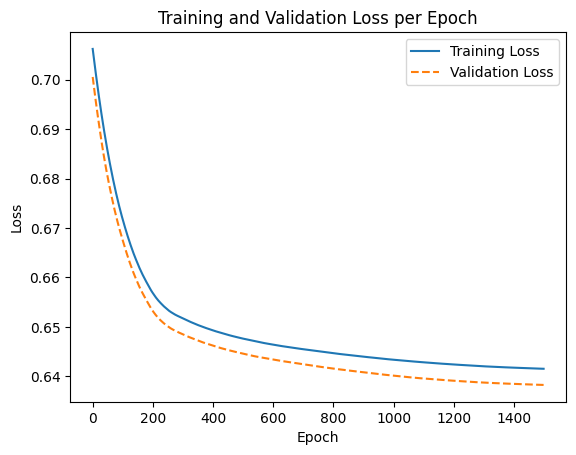

In [33]:
import networkx as nx
import matplotlib.pyplot as plt

plt.plot(upper_train, label='Training Loss')
plt.plot(upper_val, label='Validation Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.show()

### 提案手法

In [34]:
num_components = len(attributes[0])

"データセット"
data_X = [[0] * num_components for _ in range(len(train_data1))]
data_Y = train_data1

"モデル定義"
# モデル、損失関数、最適化関数の設定
proposed_model = Model(num_components)  # 要素数+初期状態
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(proposed_model.parameters(), lr=args.lr)

proposed_model = proposed_model.to(device)

proposed_train, proposed_val = model_train(attributes, data_X, data_Y, args, proposed_model, criterion, optimizer, proposed_save_path)

n_components 16
n_s 283
Train data: 175, Validation data: 51
Train X: torch.Size([175, 16]), Train Y: torch.Size([175, 16])
Epoch 100, Loss: 0.6572
Epoch 200, Loss: 0.6369
Epoch 300, Loss: 0.6283
Epoch 400, Loss: 0.6234
Epoch 500, Loss: 0.6192
Epoch 600, Loss: 0.6159
Epoch 700, Loss: 0.6132
Epoch 800, Loss: 0.6112
Epoch 900, Loss: 0.6094
Epoch 1000, Loss: 0.6078
Epoch 1100, Loss: 0.6065
Epoch 1200, Loss: 0.6053
Epoch 1300, Loss: 0.6043
Epoch 1400, Loss: 0.6034
Epoch 1500, Loss: 0.6026
Best validation loss: 0.5928702354431152


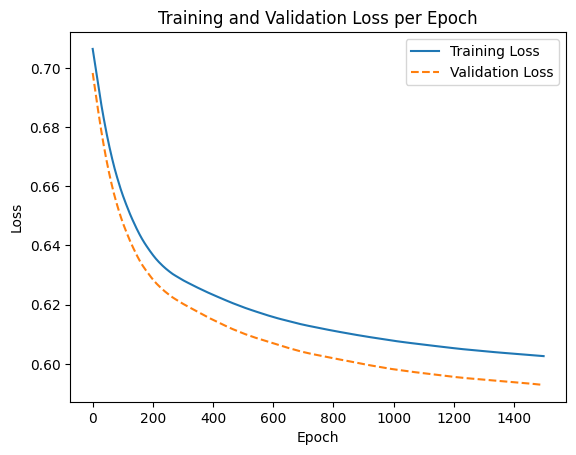

In [35]:
import networkx as nx
import matplotlib.pyplot as plt

plt.plot(proposed_train, label='Training Loss')
plt.plot(proposed_val, label='Validation Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.show()

#### モデルのロード

In [36]:
num_components = len(attributes[0])

# モデルのインスタンスを作成
upper_model = Model(num_components)
proposed_model = Model(num_components)

# 保存した `state_dict` をロード
upper_model.load_state_dict(torch.load(upper_save_path))
proposed_model.load_state_dict(torch.load(proposed_save_path))

# モデルを適切なデバイスへ移動
upper_model = upper_model.to(device)
proposed_model = proposed_model.to(device)

# 推論モードに設定
upper_model.eval()
proposed_model.eval()

/var/folders/zg/773ptkr55z99zw26dvy19_v00000gn/T/ipykernel_17960/1111777210.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  upper_model.load_state_dict(torch.load(upper_

Model(
  (fc): Linear(in_features=16, out_features=16, bias=True)
)

In [ ]:
states = [state for state in itertools.product([0, 1], repeat=num_components)]
states = sorted(states, key=lambda state: sum(state))

# 状態ごとの学生数をカウント
state_counts = defaultdict(int)
for i in range(len(attributes)):
    state_tuple = tuple(map(int, attributes[i]))
    state_counts[state_tuple] += 1

# 0でないものだけを表示
filtered_counts = {state: count for state, count in state_counts.items() if count > 0}

# # 表示
# for state, count in filtered_counts.items():
#     print(f"State: {state}, Count: {count}")
# print(state_counts[(0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0)])

import itertools
from collections import defaultdict

# 状態リスト
num_components = 16
states = [state for state in itertools.product([0, 1], repeat=num_components)]
states = sorted(states, key=lambda state: sum(state))

# 状態ごとのカウント
state_counts = defaultdict(int)
for i in range(len(attributes)):
    state_tuple = tuple(map(int, attributes[i]))
    state_counts[state_tuple] += 1

# 0 でないものだけを取得
filtered_states = [state for state, count in state_counts.items() if count > 0]

# ハミング距離1のペアをカウントする関数
def count_one_bit_difference_pairs(state_list):
    state_set = set(state_list)  # 高速検索用にセット化
    count = 0

    checked_pairs = set()  # 既にチェックしたペアを保存（重複を防ぐ）

    for state in state_list:
        for i in range(num_components):  # 各ビットについて
            flipped_state = tuple(state[j] if j != i else 1 - state[j] for j in range(num_components))  # 1ビット反転
            
            # 反転した状態がリスト内にあり、まだカウントしていないペアならカウント
            if flipped_state in state_set and (state, flipped_state) not in checked_pairs and (flipped_state, state) not in checked_pairs:
                count += 1
                checked_pairs.add((state, flipped_state))  # ペアを記録

    return count

# 実行
pair_count = count_one_bit_difference_pairs(filtered_states)
print("1ビット違いの状態のペアの数:", pair_count)

1ビット違いの状態のペアの数: 152


In [38]:
predicted_attributes = []
upper_predicted_attributes = []
com_proposed_input = []
num_components = len(test_input[0])
for i in range(len(test_input)):
    # 提案モデル
    attribute = torch.tensor(test_input[i], dtype=torch.float32)
    c = torch.ones(num_components, dtype=torch.float32)
    c = c - attribute
    get_attribute = test_target[i]
    for _ in range(int(sum(get_attribute))):
        if c.sum() <= 1:
            prob = c
        else:
            prob = proposed_model(attribute , c)  # 状態から遷移確率を計算
        attribute = prob + attribute  # 状態の更新
        c = relu(c - prob)  # 予算の更新

    # 上限モデル
    upper_attribute = torch.tensor(test_input[i], dtype=torch.float32)
    upper_c = torch.ones(num_components, dtype=torch.float32)
    upper_c = upper_c - upper_attribute
    get_attribute = test_target[i]
    for _ in range(int(sum(get_attribute))):
        if upper_c.sum() <= 1:
            upper_prob = upper_c
        else:
            upper_prob = upper_model(upper_attribute , upper_c)  # 状態から遷移確率を計算
        upper_attribute = upper_prob + upper_attribute  # 状態の更新
        upper_c = relu(upper_c - upper_prob)  # 予算の更新

    # 比較
    com_prob = []
    total = 0
    for j in range(num_components):
        if attribute[j] == 0 and sum(get_attribute) != 0:
            next_attribute = list(attribute.tolist())
            next_attribute[j] = 1
            next_attribute = tuple(next_attribute)
            # print(state_counts[next_attribute])
            com_prob.append(state_counts[next_attribute])
            total += state_counts[next_attribute]
        else:
            com_prob.append(0)
    if total != 0 and sum(get_attribute) != 0:
        # print(np.array(com_prob)/total)
        com_proposed_input.append(np.array(com_prob)/total)
    else:
        com_proposed_input.append(com_prob)

    predicted_attributes.append(attribute.detach().numpy()-test_input[i])
    upper_predicted_attributes.append(upper_attribute.detach().numpy()-test_input[i])

In [68]:
import numpy as np

difficulties = np.sum(train_data1, axis=0)  # 難易度（各スキルの出現回数）
difficulties = difficulties / difficulties.sum()  # 正規化
print(difficulties)
# difficulties2 = np.sum(train_data1+train_data2, axis=0)
# difficulties = difficulties2 + difficulties
# print(difficulties)

top_k_accuracies = []
upper_topk_accuracies = []
top_k_random_accuracies = []
top_k_difficulties_accuracies = []

match_rate = []
upper_match_rate = []

proposed_scores = []
upper_proposed_scores = []
random_scores = []
difficulties_scores = []

ce = []
upper_ce = []
d_ce = []
uniform_ce = []

for i in range(len(test_target)):
    get_attribute = test_target[i]
    k = int(sum(get_attribute))  # 1の個数を取得（明示的に int に変換）

    if k == 0:
        continue  # 1がない場合はスキップ
    
    # get_attribute の 1 の部分のインデックスを取得
    true_top_k = set(np.where(get_attribute == 1)[0])

    # predicted_attributes[i] の上位 k 個のインデックスを取得
    pred_top_k = set(np.argsort(predicted_attributes[i])[-k:])  # k を int に変換したのでOK
    upper_pred_top_k = set(np.argsort(upper_predicted_attributes[i])[-k:])
    # 一致するインデックスの数を計算
    accuracy = len(pred_top_k & true_top_k) / k  # 一致数 / k で正解率を計算
    upper_accuracy = len(upper_pred_top_k & true_top_k) / k
    
    # ランダム
    random_top_k = set(np.where(test_input[i] == 0)[0])
    random_top_k = set(np.random.choice(list(random_top_k), k, replace=False))
    # 一致率を計算
    random_accuracy = len(random_top_k & true_top_k) / k

    # 難易度ベース
    candidate_indices = np.where(test_input[i] == 0)[0]  # [1, 3, 4]
    candidate_difficulties = difficulties[candidate_indices]
    sorted_indices = candidate_indices[np.argsort(candidate_difficulties)[::-1]]
    top_k_indices = sorted_indices[:k]
    difficulties_accuracy = len(set(top_k_indices) & true_top_k) / k

    top_k_accuracies.append(accuracy)
    top_k_random_accuracies.append(random_accuracy)
    upper_topk_accuracies.append(upper_accuracy)
    top_k_difficulties_accuracies.append(difficulties_accuracy)

    # 補正スコア
    difficulty_sum = sum(difficulties[j] for j in random_top_k)
    # print(len(true_top_k))
    # print(len(pred_top_k & true_top_k))
    # print("accuracy", accuracy)
    # for j in pred_top_k & true_top_k:
    #     value = predicted_attributes[i][j]
    #     difficulty = (difficulties[j] / difficulty_sum)
    #     print(f"predicted_attributes[{i}][{j}] = {value}, difficulties[{j}] = {difficulty}")
    #     # 必要に応じて計算結果も出力
    #     print(f" → {value} / {difficulty} = {value / difficulty}")
    proposed_score = sum(predicted_attributes[i][j]/(difficulties[j] / difficulty_sum) for j in pred_top_k & true_top_k)/k
    # print(proposed_score)
    proposed_scores.append(proposed_score)
    upper_proposed_score = sum(upper_predicted_attributes[i][j]/(difficulties[j] / difficulty_sum) for j in upper_pred_top_k & true_top_k)/k
    upper_proposed_scores.append(upper_proposed_score)
    random_score = sum((1/len(random_top_k & true_top_k))/(difficulties[j] / difficulty_sum) for j in random_top_k & true_top_k)/k
    random_scores.append(random_score)
    difficulties_score = sum(1 for j in set(top_k_indices) & true_top_k)/k
    difficulties_scores.append(difficulties_score)

    # print("diff", len(pred_top_k&set(top_k_indices)), len(upper_pred_top_k&set(top_k_indices))/k, upper_proposed_score)
    match_rate.append(len(pred_top_k&set(top_k_indices))/k)
    upper_match_rate.append(len(upper_pred_top_k&set(top_k_indices))/k)

    ce.append(-np.mean(np.log(predicted_attributes[i][list(true_top_k)])))
    upper_ce.append(-np.mean(np.log(upper_predicted_attributes[i][list(true_top_k)])))
    d_ce.append(-np.mean(np.log(difficulties[list(true_top_k)]/difficulty_sum)))
    uniform_ce.append(-np.log(1/len(list(true_top_k))))



print("aaa")
print(np.array(predicted_attributes).shape)
print(difficulties.shape)
# 平均を計算（リストが空でない場合のみ）
average_accuracy = np.mean(top_k_accuracies) if top_k_accuracies else 0.0
average_random_accuracy = np.mean(top_k_random_accuracies) if top_k_random_accuracies else 0.0
average_upper_accuracy = np.mean(upper_topk_accuracies) if upper_topk_accuracies else 0.0
average_difficulties_accuracy = np.mean(top_k_difficulties_accuracies) if top_k_difficulties_accuracies else 0.0

average_match_rate = np.mean(match_rate) if match_rate else 0.0
average_upper_match_rate = np.mean(upper_match_rate) if upper_match_rate else 0.0

ce = np.mean(ce) if ce else 0.0
upper_ce = np.mean(upper_ce) if upper_ce else 0.0
d_ce = np.mean(d_ce) if d_ce else 0.0
uniform_ce = np.mean(uniform_ce) if uniform_ce else 0.0

average_proposed_score = np.mean(proposed_scores) if proposed_scores else 0.0
average_upper_proposed_score = np.mean(upper_proposed_scores) if upper_proposed_scores else 0.0
average_random_score = np.mean(random_scores) if random_scores else 0.0
average_difficulties_score = np.mean(difficulties_scores) if difficulties_scores else 0.0

# 結果の表示
# print(f"Top-k accuracies: {top_k_accuracies}")
# print(f"Top-k random accuracies: {top_k_random_accuracies}") # ランダムの場合
# print(f"Upper Top-k accuracies: {upper_topk_accuracies}")
# print(f"Top-k difficulties accuracies: {top_k_difficulties_accuracies}")

print(f"Average accuracy: {average_accuracy:.4f}")
print(f"Average upper accuracy: {average_upper_accuracy:.4f}")
print(f"Average random accuracy: {average_random_accuracy:.4f}")
print(f"Average difficulties accuracy: {average_difficulties_accuracy:.4f}")
print(average_accuracy, average_upper_accuracy, average_difficulties_accuracy, average_random_accuracy)

print(f"難易度ベースとの出力一致率: {average_match_rate:.4f}")
print(f"難易度ベースとの出力一致率（上限モデル）: {average_upper_match_rate:.4f}")

# 値が小さい方が良い
print(f"Cross Entropy: {ce:.4f}")
print(f"Upper Cross Entropy: {upper_ce:.4f}")
print(f"Difficulty Cross Entropy: {d_ce:.4f}")
print(f"Uniform Cross Entropy: {uniform_ce:.4f}")

# あんま変わらん？
# 補正スコア
print(f"Average proposed score: {average_proposed_score:.4f}")
print(f"Average upper proposed score: {average_upper_proposed_score:.4f}")
print(f"Average random score: {average_random_score:.4f}")
print(f"Average difficulties score: {average_difficulties_score:.4f}")

[0.0368932  0.04902913 0.03203883 0.01699029 0.09951456 0.09854369
 0.09854369 0.09029126 0.07475728 0.07475728 0.09029126 0.02378641
 0.08058252 0.03786408 0.06699029 0.02912621]
aaa
(57, 16)
(16,)
Average accuracy: 0.7285
Average upper accuracy: 0.7237
Average random accuracy: 0.4700
Average difficulties accuracy: 0.7237
0.7284580498866213 0.7236961451247167 0.7236961451247167 0.4699546485260771
難易度ベースとの出力一致率: 0.9714
難易度ベースとの出力一致率（上限モデル）: 1.0000
Cross Entropy: 0.6812
Upper Cross Entropy: 0.6743
Difficulty Cross Entropy: 0.9876
Uniform Cross Entropy: 1.1096
Average proposed score: 1.8780
Average upper proposed score: 1.8546
Average random score: 0.7702
Average difficulties score: 0.7237


In [ ]:
# 表示オプションを設定（有効数字3桁）
torch.set_printoptions(precision=3, sci_mode=False)

for param in proposed_model.parameters():
    print(param)

for param in upper_model.parameters():
    print(param)

Parameter containing:
tensor([[     0.000,     -0.000,     -0.000,     -0.000,     -0.001,     -0.334,
             -0.002,     -0.033,     -0.000,     -0.001,      0.000,      0.000,
             -0.000,     -0.000,      0.000,      0.000],
        [     0.000,     -0.000,      0.000,      0.000,      0.000,      0.000,
              0.000,      0.000,      0.000,      0.000,      0.000,     -0.000,
             -0.000,      0.000,      0.000,      0.000],
        [     0.000,      0.000,      0.000,      0.000,     -0.116,     -0.404,
             -0.511,     -0.365,     -0.000,     -0.001,     -0.065,     -0.000,
             -0.062,     -0.000,     -0.001,     -0.000],
        [    -0.000,     -0.000,     -0.000,      0.000,     -0.222,     -0.225,
             -0.263,     -0.424,      0.000,     -0.130,     -0.717,     -0.000,
             -0.078,     -0.000,     -0.126,      0.000],
        [     0.000,     -0.000,     -0.000,      0.000,      0.001,      0.000,
              0.0